In [1]:
import pandasai as pai
from pandasai_litellm.litellm import LiteLLM

In [2]:
# Initialize LiteLLM with your OpenAI model
llm = LiteLLM(model="ollama/llama3", api_key="http://localhost:11434/api")

In [3]:
# Configure PandasAI to use this LLM
pai.config.set({
    "llm": llm
})


{'type': 'plot', 'value': 'exports\\charts\\temp_chart_59379223-5215-4a83-8bf8-a322f9460a4e.png'}
exports\charts\temp_chart_59379223-5215-4a83-8bf8-a322f9460a4e.png


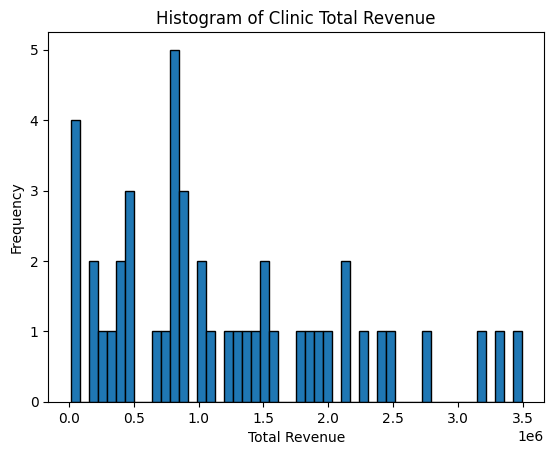

In [4]:
df = pai.read_csv("cc_clinic_level.csv")

response = df.chat("Plot the histogram of clinic showing for each one the revenue. Use different colors for each bar")
print(response)